## 4. Boyutta Shor Algoritması

In [1]:
from cmath import exp
from fractions import Fraction
from math import gcd, pi

import cirq
import numpy as np
import string
import pandas as pd

from cirq import protocols
from matplotlib import pyplot

In [2]:
# complex 0 + 1i
Imag = complex(0, 1)

A = (2 * pi * Imag / 4)
B = (4 * pi * Imag / 4)
C = (6 * pi * Imag / 4)
D = (8 * pi * Imag / 4)
E = (12 * pi * Imag / 4)
F = (18 * pi * Imag / 4)

Unitaries = [
    [
        [np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]], dtype=complex)],
        [np.array([[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=complex)],
        [np.array([[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0]], dtype=complex)],
        [np.array([[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0]], dtype=complex)]
    ],
    [
        [np.array([[1, 0, 0, 0], [0, A, 0, 0], [0, 0, B, 0], [0, 0, 0, C]], dtype=complex)],
        [np.array([[0, 0, 0, C], [1, 0, 0, 0], [0, A, 0, 0], [0, 0, B, 0]], dtype=complex)],
        [np.array([[0, 0, B, 0], [0, 0, 0, C], [1, 0, 0, 0], [0, A, 0, 0]], dtype=complex)],
        [np.array([[0, A, 0, 0], [0, 0, B, 0], [0, 0, 0, C], [1, 0, 0, 0]], dtype=complex)]
    ],
    [
        [np.array([[1, 0, 0, 0], [0, B, 0, 0], [0, 0, D, 0], [0, 0, 0, E]], dtype=complex)],
        [np.array([[0, 0, 0, E], [1, 0, 0, 0], [0, B, 0, 0], [0, 0, D, 0]], dtype=complex)],
        [np.array([[0, 0, D, 0], [0, 0, 0, E], [1, 0, 0, 0], [0, B, 0, 0]], dtype=complex)],
        [np.array([[0, B, 0, 0], [0, 0, D, 0], [0, 0, 0, E], [1, 0, 0, 0]], dtype=complex)]

    ],
    [
        [np.array([[1, 0, 0, 0], [0, C, 0, 0], [0, 0, E, 0], [0, 0, 0, F]], dtype=complex)],
        [np.array([[0, 0, 0, F], [1, 0, 0, 0], [0, C, 0, 0], [0, 0, E, 0]], dtype=complex)],
        [np.array([[0, 0, E, 0], [0, 0, 0, F], [1, 0, 0, 0], [0, C, 0, 0]], dtype=complex)],
        [np.array([[0, C, 0, 0], [0, 0, E, 0], [0, 0, 0, F], [1, 0, 0, 0]], dtype=complex)]
    ]
]

In [3]:
class Id(cirq.Gate):
    """ ID gate for multi dimension. """

    def __init__(self, dimension):
        super(Id, self)
        self.dimension = dimension

    def _qid_shape_(self):
        return self.dimension,

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        zero = np.zeros(shape=(self.dimension, self.dimension), dtype=complex)
        for i in range(self.dimension):
            zero[i][i] = complex(1, 0)
        return zero

    def _circuit_diagram_info_(self, args):
        self.args = args
        return "I"

    @property
    def unitary(self):
        return self._unitary_()


class QuqritPhaseGate(cirq.Gate):
    def __init__(self, root):
        super(QuqritPhaseGate, self)
        self.root = root

    def _qid_shape_(self):
        return 4,

    def _num_qubits_(self):
        return 1

    def _unitary_(self):
        arr = np.array([[1, 0, 0, 0],
                        [0, exp(A / self.root), 0, 0],
                        [0, 0, exp(B / self.root), 0],
                        [0, 0, 0, exp(C / self.root)]])
        return arr

    def _circuit_diagram_info_(self, args):
        self.args = args
        return "Z{}".format(self.root)

    @property
    def unitary(self):
        return self._unitary_()


class PlusOneGate(cirq.Gate):
    """ Plus One Gate """

    def __init__(self, dimension):
        super(PlusOneGate, self)
        self.dimension = dimension

    def _qid_shape_(self):
        return self.dimension,

    def _num_qubits_(self):
        return 1

    def _unitary_(self) -> np.ndarray:
        if self.dimension == 2:
            return np.array([[0, 1], [1, 0]], dtype=complex)

        zero = np.zeros(shape=(self.dimension, self.dimension), dtype=complex)
        zero[0][self.dimension - 1] = 1
        for i in range(1, self.dimension):
            zero[i][i - 1] = complex(1, 0)
        return zero

    def _circuit_diagram_info_(self, args) -> str:
        self.args = args
        return "[+1]"

    @property
    def unitary(self):
        return self._unitary_()


class ControlledQuqritPhaseGate(cirq.Gate):
    def __init__(self, root):
        self.root = root

    def _qid_shape_(self):
        return 4, 4,

    def _unitary_(self):
        arr = np.zeros(shape=(16, 16), dtype=complex)
        arr[0][0], arr[1][1], arr[2][2], arr[3][3] = 1, 1, 1, 1
        arr[4][7], arr[5][4], arr[6][5], arr[7][6] = 1, 1, 1, 1
        arr[8][10], arr[9][11], arr[10][8], arr[11][9] = 1, exp(A / self.root), exp(B / self.root), exp(C / self.root)
        arr[12][13], arr[13][14], arr[14][15], arr[15][12] = 1, exp(A / self.root), exp(B / self.root), exp(C / self.root)
        return arr

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    def _circuit_diagram_info_(self, args):
        return protocols.CircuitDiagramInfo(
            wire_symbols=('@', 'Z{}'.format(self.root)))

    def __str__(self):
        return str(self._unitary_())

class QuqritHadamard(cirq.Gate):
    def _qid_shape_(self):
        return 4,

    @staticmethod
    def _unitary_():
        arr = np.array([
            [1, 1, 1, 1],
            [1, exp(A), exp(B), exp(C)],
            [1, exp(B), exp(D), exp(E)],
            [1, exp(C), exp(E), exp(F)]
        ], dtype=complex)
        arr *= 1 / 2
        return arr

    @staticmethod
    def _circuit_diagram_info_(args):
        return 'H'

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    def __str__(self):
        return str(self._unitary_())


class QuqritHadamardHermitik(cirq.Gate):
    def _qid_shape_(self):
        return 4,

    @staticmethod
    def _unitary_():
        return QuqritHadamard().transform_matrix.conjugate().T

    @staticmethod
    def _circuit_diagram_info_(args):
        return 'Ht'

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    def __str__(self):
        return str(self._unitary_())


class QuqritCNOT(cirq.Gate):
    def _qid_shape_(self):
        return 4, 4,

    @staticmethod
    def _unitary_():
        arr = np.zeros(shape=(16, 16), dtype=complex)
        arr[0][0], arr[1][1], arr[2][2], arr[3][3] = 1, 1, 1, 1
        arr[4][7], arr[5][4], arr[6][5], arr[7][6] = 1, 1, 1, 1
        arr[8][10], arr[9][11], arr[10][8], arr[11][9] = 1, 1, 1, 1
        arr[12][13], arr[13][14], arr[14][15], arr[15][12] = 1, 1, 1, 1
        return arr

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    @staticmethod
    def _circuit_diagram_info_(args):
        return protocols.CircuitDiagramInfo(
            wire_symbols=('@', 'X'))

    def __str__(self):
        return str(self._unitary_())


class QutritCNOTHermitik(cirq.Gate):
    def _qid_shape_(self):
        return 4, 4,

    @staticmethod
    def _unitary_():
        return QuqritCNOT().transform_matrix.conjugate().T

    @staticmethod
    def _circuit_diagram_info_(args):
        return protocols.CircuitDiagramInfo(
            wire_symbols=('@\'', 'X'))

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    def __str__(self):
        return str(self._unitary_())


class QuqritMod15Gate(cirq.Gate):
    def __init__(self, count):
        super(QuqritMod15Gate, self).__init__()
        self.count = count

    def _qid_shape_(self):
        return 4, 4,

    def _unitary_(self):
        arr = np.zeros(shape=(16, 16), dtype=complex)
        arr[15][0] = 1
        arr[14][2] = 1
        arr[13][4] = 1
        arr[12][6] = 1
        arr[11][8] = 1
        arr[10][10] = 1
        arr[9][12] = 1
        arr[8][14] = 1
        arr[7][1] = 1
        arr[6][3] = 1
        arr[5][5] = 1
        arr[4][7] = 1
        arr[3][9] = 1
        arr[2][11] = 1
        arr[1][13] = 1
        arr[0][15] = 1

        if self.count == 1:
            return arr

        for i in range(self.count - 1):
            arr = arr.dot(arr)
        return arr

    def _circuit_diagram_info_(self, args):
        return protocols.CircuitDiagramInfo(
            wire_symbols=('W{}'.format(self.count), 'W'))

    @property
    def transform_matrix(self) -> np.ndarray:
        return self._unitary_()

    def __str__(self):
        return str(self._unitary_())

In [4]:
def test(shots):
    quqrit_count = 6  #(4 + 2 sayma için)
    quqrits = cirq.LineQid.range(quqrit_count, dimension=4)
    
    # Devre hazırlanıyor.
    circuit = cirq.Circuit()
    circuit.append(QuqritHadamard().on_each(quqrits[0], quqrits[1], quqrits[2], quqrits[3]))
    circuit.append(Id(4).on(quqrits[4]))
    circuit.append(PlusOneGate(4).on(quqrits[5]))

    # MOD15 Devresi kontrollü şekilde ekleniyor.
    circuit.append(QuqritMod15Gate(1).controlled(1, control_values=[(1, 3)], control_qid_shape=(4,)).on(quqrits[0], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(2).controlled(1, control_values=[(2, 3)], control_qid_shape=(4,)).on(quqrits[0], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(4).controlled(1, control_values=[(1, 3)], control_qid_shape=(4,)).on(quqrits[1], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(8).controlled(1, control_values=[(2, 3)], control_qid_shape=(4,)).on(quqrits[1], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(16).controlled(1, control_values=[(1, 3)], control_qid_shape=(4,)).on(quqrits[2], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(32).controlled(1, control_values=[(2, 3)], control_qid_shape=(4,)).on(quqrits[2], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(64).controlled(1, control_values=[(1, 3)], control_qid_shape=(4,)).on(quqrits[3], quqrits[4], quqrits[5]))
    circuit.append(QuqritMod15Gate(128).controlled(1, control_values=[(2, 3)], control_qid_shape=(4,)).on(quqrits[3], quqrits[4], quqrits[5]))
    
    # QFT Tersi ekleniyor.
    circuit.append(QuqritHadamard().on(quqrits[3]))
    circuit.append(ControlledQuqritPhaseGate(1).on(quqrits[3], quqrits[2]))
    circuit.append(QuqritHadamard().on(quqrits[2]))
    circuit.append(ControlledQuqritPhaseGate(-2).on(quqrits[3], quqrits[1]))
    circuit.append(ControlledQuqritPhaseGate(1).on(quqrits[2], quqrits[1]))
    circuit.append(QuqritHadamard().on(quqrits[1]))
    circuit.append(ControlledQuqritPhaseGate(-4).on(quqrits[3], quqrits[0]))
    circuit.append(ControlledQuqritPhaseGate(-2).on(quqrits[2], quqrits[0]))
    circuit.append(ControlledQuqritPhaseGate(1).on(quqrits[1], quqrits[0]))
    circuit.append(QuqritHadamard().on(quqrits[0]))
    
    # Ölçümler ekleniyor.
    circuit.append(cirq.measure(quqrits[0], key="{}".format(0)))
    circuit.append(cirq.measure(quqrits[1], key="{}".format(1)))
    circuit.append(cirq.measure(quqrits[2], key="{}".format(2)))
    circuit.append(cirq.measure(quqrits[3], key="{}".format(3)))

    print(circuit)
    sim = cirq.Simulator()
    res = sim.run(circuit, repetitions=shots)
    
    # Plotlama için hazırlanıyor.
    result_histogram = list()
    plot = dict()
    for i in range(shots):
        new_string = str()
        for j in range(4):
            value = res.measurements["{}".format(j)][i][0]
            if value == 0:
                new_string += "00"
            elif value == 1:
                new_string += "01"
            elif value == 2:
                new_string += "10"
            else:
                new_string += "11"
        try:
            plot[new_string] += 1
        except KeyError:
            plot[new_string] = 1

        result_histogram.append(new_string)
    
    pyplot.bar(plot.keys(), plot.values())
    pyplot.title("4 boyutta Shor sonuçları")
    pyplot.xlabel("Durumlar (iki boyuta dönüşmüş)")
    pyplot.ylabel("Adet")
    
    rows, measured_phases = [], []
    for output in plot.keys():
        decimal = int(output, 2)
        phase = decimal / (2 ** 8)
        measured_phases.append(phase)

        rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                     f"{decimal}/{2 ** 8} = {phase:.2f}"])

    headers = ["8Bit çıktı", "Faz"]
    df = pd.DataFrame(rows, columns=headers)
    print(df)

    rows = []
    r = 0
    new_frac = 0.0
    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(15)
        rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
        
        if frac.denominator == r:
            if frac.numerator/frac.denominator > new_frac:
                new_frac = frac.numerator/frac.denominator
                
        if frac.denominator > r:
            r = frac.denominator
            new_frac = frac.numerator/frac.denominator
    
    print("\nBulunan frekans: ", r, "\n")
    headers = ["Faz", "Kesit", "R"]
    df = pd.DataFrame(rows, columns=headers)
    print(df)

    frac = Fraction(new_frac).limit_denominator(15)
    s, r = frac.numerator, frac.denominator

    tahminler = [gcd(7 ** (r // 2) - 1, 15), gcd(7 ** (r // 2) + 1, 15)]
    print("Tahminler: ", tahminler)

                                                                                            ┌────┐   ┌─────┐   ┌─────────┐
0 (d=4): ───H──────(1,3)───(2,3)────────────────────────────────────────────────────────────────────────Z-4───────────Z-2────Z1───────H────────M('0')───
                   │       │                                                                            │             │      │
1 (d=4): ───H──────┼───────┼───────(1,3)───(2,3)──────────────────────────────────────────────Z-2─────Z1┼───────H─────┼──────@────────M('1')────────────
                   │       │       │       │                                                  │       │ │             │
2 (d=4): ───H──────┼───────┼───────┼───────┼───────(1,3)───(2,3)───────────────────────Z1────H┼───────@─┼─────────────@──────M('2')─────────────────────
                   │       │       │       │       │       │                           │      │         │
3 (d=4): ───H──────┼───────┼───────┼───────┼───────┼───────┼─────

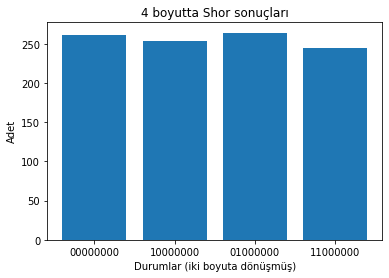

In [5]:
test(shots=1024)